In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

In [2]:
spread_df = pd.DataFrame([])

for year in range(2017,2025):
    load_df = pd.read_csv(f"spread_data/ercot_spreads_{year}_HB_NORTH.csv")
    spread_df = pd.concat([spread_df,load_df])
spread_df['datetime'] = pd.to_datetime(spread_df['Interval Start'])
spread_df.drop('Interval Start',axis=1,inplace=True)
spread_df.set_index('datetime',inplace=True)
spread_df

C:\Users\qwane\AppData\Local\Temp\ipykernel_23652\1186990896.py:6: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  spread_df['datetime'] = pd.to_datetime(spread_df['Interval Start'])


,da_price,rt_price,spread
datetime,,,
2017-01-01 00:00:00-06:00,23.23,23.3575,0.1275
2017-01-01 01:00:00-06:00,21.82,21.4650,-0.3550
2017-01-01 02:00:00-06:00,20.16,20.7350,0.5750
2017-01-01 03:00:00-06:00,20.00,20.2700,0.2700
2017-01-01 04:00:00-06:00,20.24,20.1200,-0.1200
...,...,...,...
2024-12-31 19:00:00-06:00,35.70,36.9375,1.2375
2024-12-31 20:00:00-06:00,31.97,26.8275,-5.1425
2024-12-31 21:00:00-06:00,25.64,22.5675,-3.0725


In [3]:
fuel_df = pd.DataFrame([])

for year in range(2017,2025):
    load_df = pd.read_csv(f"FuelMixReport_PreviousYears/ercot_generation_by_fuel_{year}_timeseries_from_excel.csv")
    fuel_df = pd.concat([fuel_df,load_df])
fuel_df['datetime'] = pd.to_datetime(fuel_df['datetime'])
fuel_df = fuel_df.sort_values(by='datetime')
fuel_df['datetime'] = fuel_df['datetime'].dt.tz_localize('America/Chicago',ambiguous='NaT')
fuel_df = fuel_df.set_index("datetime")
fuel_df = fuel_df.resample("H").mean()
fuel_df

C:\Users\qwane\AppData\Local\Temp\ipykernel_23652\306733099.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fuel_df = fuel_df.resample("H").mean()


,Biomass,Coal,Gas,Gas-CC,Hydro,Nuclear,Other,Solar,Wind,WSL
datetime,,,,,,,,,,
2016-12-31 23:00:00-06:00,13.516539,2194.360961,204.550559,784.408180,8.663920,1278.015976,1.285530,0.000000,2886.245382,NaN
2017-01-01 00:00:00-06:00,14.078397,4301.683482,216.452667,1012.427502,8.741264,1277.877442,0.835140,0.000000,536.198129,NaN
2017-01-01 01:00:00-06:00,14.085902,4150.264314,215.262631,944.536994,8.707971,1277.891483,0.825129,0.000000,575.906728,NaN
2017-01-01 02:00:00-06:00,14.077276,3974.941870,214.365778,931.357776,8.684306,1277.958668,0.823215,0.000000,647.490914,NaN
2017-01-01 03:00:00-06:00,14.085040,3842.683486,214.587102,928.815018,8.689504,1277.931763,0.821280,0.000000,686.759563,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00-06:00,3.050701,2401.034306,741.254966,5425.303910,34.490322,1269.685375,188.148816,0.000290,1844.143594,-13.430481
2024-12-31 20:00:00-06:00,3.049541,2351.588716,537.359313,5270.597999,29.162038,1269.620165,47.900979,0.001852,2230.998802,-66.203461
2024-12-31 21:00:00-06:00,3.051928,2119.150003,420.957891,5132.516643,1.252014,1270.710497,13.716939,0.000068,2633.881343,-155.302472


In [4]:
df = pd.concat([spread_df,fuel_df],axis=1,join='inner')
df = df.round(4)
df.to_csv('spread.csv')
df

,da_price,rt_price,spread,Biomass,Coal,Gas,Gas-CC,Hydro,Nuclear,Other,Solar,Wind,WSL
datetime,,,,,,,,,,,,,
2017-01-01 00:00:00-06:00,23.23,23.3575,0.1275,14.0784,4301.6835,216.4527,1012.4275,8.7413,1277.8774,0.8351,0.0000,536.1981,NaN
2017-01-01 01:00:00-06:00,21.82,21.4650,-0.3550,14.0859,4150.2643,215.2626,944.5370,8.7080,1277.8915,0.8251,0.0000,575.9067,NaN
2017-01-01 02:00:00-06:00,20.16,20.7350,0.5750,14.0773,3974.9419,214.3658,931.3578,8.6843,1277.9587,0.8232,0.0000,647.4909,NaN
2017-01-01 03:00:00-06:00,20.00,20.2700,0.2700,14.0850,3842.6835,214.5871,928.8150,8.6895,1277.9318,0.8213,0.0000,686.7596,NaN
2017-01-01 04:00:00-06:00,20.24,20.1200,-0.1200,14.0157,3783.5797,212.1251,989.8101,8.6354,1278.0895,0.7218,0.0000,688.6356,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00-06:00,35.70,36.9375,1.2375,3.0507,2401.0343,741.2550,5425.3039,34.4903,1269.6854,188.1488,0.0003,1844.1436,-13.4305
2024-12-31 20:00:00-06:00,31.97,26.8275,-5.1425,3.0495,2351.5887,537.3593,5270.5980,29.1620,1269.6202,47.9010,0.0019,2230.9988,-66.2035
2024-12-31 21:00:00-06:00,25.64,22.5675,-3.0725,3.0519,2119.1500,420.9579,5132.5166,1.2520,1270.7105,13.7169,0.0001,2633.8813,-155.3025


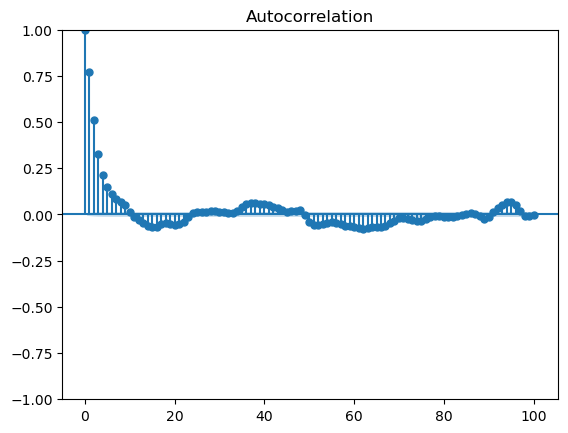

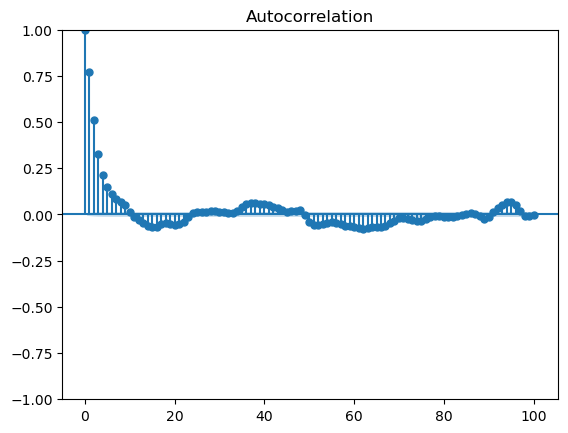

In [5]:
plot_acf(df['spread'], lags=100)

# Train

In [6]:
feature_columns = [col for col in df.columns if col!= "spread"]
X = df[feature_columns].shift(1)
y = df["spread"]

# --- 3. Split Data into Training and Testing Sets ---
# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")


Training set size: 56102 samples
Testing set size: 14026 samples


In [7]:
# --- 4. Initialize and Train the XGBoost Model ---
# We use XGBRegressor because we are predicting a number
model = xgb.XGBRegressor(
    n_estimators=1000,         # Number of trees (can be high, early stopping will find the best)
    learning_rate=0.05,        # How fast the model learns
    early_stopping_rounds=10,  # Stop if performance doesn't improve for 10 rounds
    n_jobs=-1                  # Use all available CPU cores
)

print("\n--- Training XGBoost Model ---")
# We fit the model on the training data
# We use the test data in eval_set to monitor for early stopping
model.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False  # Set to 100 to see progress every 100 trees
)
print("Model training complete.")

# --- 5. Evaluate the Model ---
print("\n--- Evaluating Model Performance ---")
# Use the trained model to make predictions on the *test* data
y_pred = model.predict(X_test)

# Calculate common regression metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f} (Closer to 1.0 is better)")


--- Training XGBoost Model ---
Model training complete.

--- Evaluating Model Performance ---
Mean Absolute Error (MAE): 15.93
Root Mean Squared Error (RMSE): 122.39
R-squared (R²): 0.50 (Closer to 1.0 is better)



--- Plotting Feature Importance ---
Feature importance plot saved to 'feature_importance.png'

--- Plotting Predictions vs. Actual ---
Prediction scatter plot saved to 'predictions_vs_actual.png'


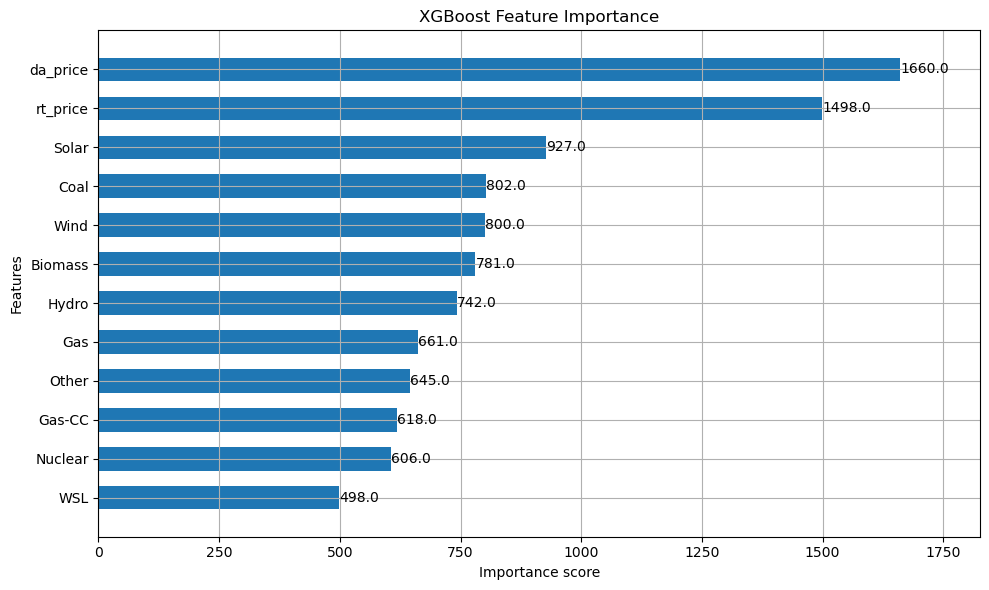

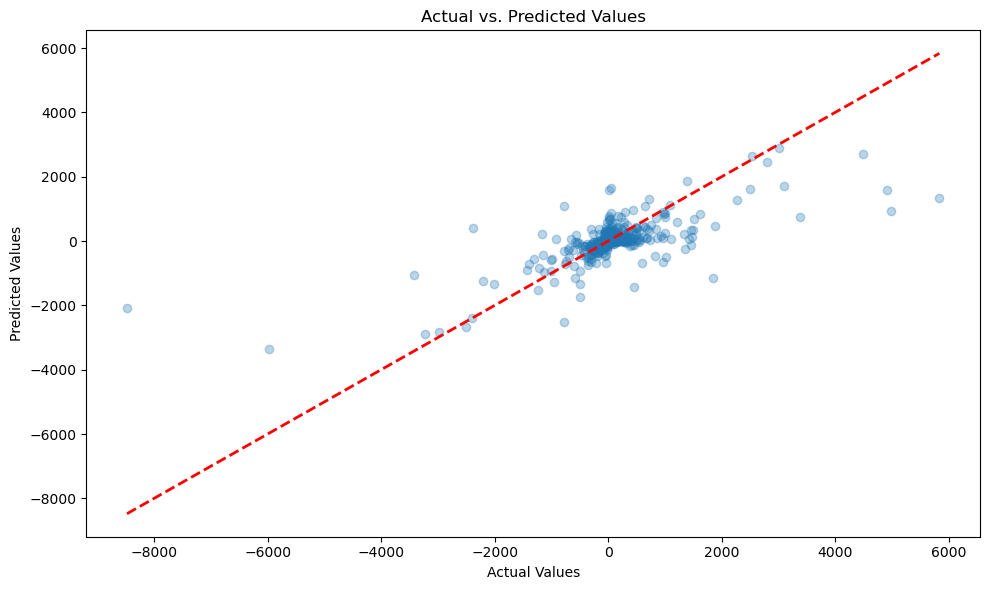

In [8]:
# --- 6. Plot Feature Importance ---
print("\n--- Plotting Feature Importance ---")
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model, ax=ax, height=0.6)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.savefig("feature_importance.png") # Save the plot
print("Feature importance plot saved to 'feature_importance.png'")

# --- 7. Plot Predictions vs. Actual ---
print("\n--- Plotting Predictions vs. Actual ---")
plt.figure(figsize=(10, 6))
# A scatter plot of actual (y_test) vs. predicted (y_pred)
plt.scatter(y_test, y_pred, alpha=0.3)
# A 45-degree line represents a perfect prediction
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.tight_layout()
plt.savefig("predictions_vs_actual.png")
print("Prediction scatter plot saved to 'predictions_vs_actual.png'")

# Walk-Forward

In [9]:
df= pd.read_csv("spread.csv").set_index('datetime')
df.index = pd.to_datetime(df.index,utc=True)
df

,da_price,rt_price,spread,Biomass,Coal,Gas,Gas-CC,Hydro,Nuclear,Other,Solar,Wind,WSL
datetime,,,,,,,,,,,,,
2017-01-01 06:00:00+00:00,23.23,23.3575,0.1275,14.0784,4301.6835,216.4527,1012.4275,8.7413,1277.8774,0.8351,0.0000,536.1981,NaN
2017-01-01 07:00:00+00:00,21.82,21.4650,-0.3550,14.0859,4150.2643,215.2626,944.5370,8.7080,1277.8915,0.8251,0.0000,575.9067,NaN
2017-01-01 08:00:00+00:00,20.16,20.7350,0.5750,14.0773,3974.9419,214.3658,931.3578,8.6843,1277.9587,0.8232,0.0000,647.4909,NaN
2017-01-01 09:00:00+00:00,20.00,20.2700,0.2700,14.0850,3842.6835,214.5871,928.8150,8.6895,1277.9318,0.8213,0.0000,686.7596,NaN
2017-01-01 10:00:00+00:00,20.24,20.1200,-0.1200,14.0157,3783.5797,212.1251,989.8101,8.6354,1278.0895,0.7218,0.0000,688.6356,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 01:00:00+00:00,35.70,36.9375,1.2375,3.0507,2401.0343,741.2550,5425.3039,34.4903,1269.6854,188.1488,0.0003,1844.1436,-13.4305
2025-01-01 02:00:00+00:00,31.97,26.8275,-5.1425,3.0495,2351.5887,537.3593,5270.5980,29.1620,1269.6202,47.9010,0.0019,2230.9988,-66.2035
2025-01-01 03:00:00+00:00,25.64,22.5675,-3.0725,3.0519,2119.1500,420.9579,5132.5166,1.2520,1270.7105,13.7169,0.0001,2633.8813,-155.3025


In [10]:
df.index = pd.to_datetime(pd.to_datetime(df.index.to_series(),utc=True).dt.strftime('%Y-%m-%d %H:%M:%S'))
df

,da_price,rt_price,spread,Biomass,Coal,Gas,Gas-CC,Hydro,Nuclear,Other,Solar,Wind,WSL
datetime,,,,,,,,,,,,,
2017-01-01 06:00:00,23.23,23.3575,0.1275,14.0784,4301.6835,216.4527,1012.4275,8.7413,1277.8774,0.8351,0.0000,536.1981,NaN
2017-01-01 07:00:00,21.82,21.4650,-0.3550,14.0859,4150.2643,215.2626,944.5370,8.7080,1277.8915,0.8251,0.0000,575.9067,NaN
2017-01-01 08:00:00,20.16,20.7350,0.5750,14.0773,3974.9419,214.3658,931.3578,8.6843,1277.9587,0.8232,0.0000,647.4909,NaN
2017-01-01 09:00:00,20.00,20.2700,0.2700,14.0850,3842.6835,214.5871,928.8150,8.6895,1277.9318,0.8213,0.0000,686.7596,NaN
2017-01-01 10:00:00,20.24,20.1200,-0.1200,14.0157,3783.5797,212.1251,989.8101,8.6354,1278.0895,0.7218,0.0000,688.6356,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 01:00:00,35.70,36.9375,1.2375,3.0507,2401.0343,741.2550,5425.3039,34.4903,1269.6854,188.1488,0.0003,1844.1436,-13.4305
2025-01-01 02:00:00,31.97,26.8275,-5.1425,3.0495,2351.5887,537.3593,5270.5980,29.1620,1269.6202,47.9010,0.0019,2230.9988,-66.2035
2025-01-01 03:00:00,25.64,22.5675,-3.0725,3.0519,2119.1500,420.9579,5132.5166,1.2520,1270.7105,13.7169,0.0001,2633.8813,-155.3025


In [11]:
week_sr = df.index.to_period("W")
weeks = week_sr.unique()
weeks

PeriodIndex(['2016-12-26/2017-01-01', '2017-01-02/2017-01-08',
             '2017-01-09/2017-01-15', '2017-01-16/2017-01-22',
             '2017-01-23/2017-01-29', '2017-01-30/2017-02-05',
             '2017-02-06/2017-02-12', '2017-02-13/2017-02-19',
             '2017-02-20/2017-02-26', '2017-02-27/2017-03-05',
             ...
             '2024-10-28/2024-11-03', '2024-11-04/2024-11-10',
             '2024-11-11/2024-11-17', '2024-11-18/2024-11-24',
             '2024-11-25/2024-12-01', '2024-12-02/2024-12-08',
             '2024-12-09/2024-12-15', '2024-12-16/2024-12-22',
             '2024-12-23/2024-12-29', '2024-12-30/2025-01-05'],
            dtype='period[W-SUN]', name='datetime', length=419)

In [12]:
features = [col for col in df.columns if col!= "spread"]
target = 'spread'

# Backtest parameters
threshold = 2.0  # $/MWh for trading decision

# Initialize results DataFrame for OOS predictions and PnL
results = pd.DataFrame(index=df.index, columns=['pred_spread', 'position', 'actual_spread'])

# Step 3: Walk-forward training: For each week (starting from the 2nd), train on prior data, predict that week
min_train_weeks = 4  # Minimum weeks needed to start training (e.g., 1 month of data)
for i in tqdm(range(min_train_weeks, len(weeks))):
    test_week = weeks[i]
    train_weeks = weeks[:i]  # All prior weeks
    
    # Split data
    train_mask = week_sr.isin(train_weeks)
    test_mask = week_sr == test_week
    
    X_train = df.loc[train_mask, features]
    y_train = df.loc[train_mask, target]
    X_test = df.loc[test_mask, features]
    
    if len(X_test) == 0:
        continue  # Skip empty weeks
    
    # Train XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(X_train, y_train)
    
    # Predict OOS
    pred_spread = model.predict(X_test)
    results.loc[test_mask, 'pred_spread'] = pred_spread
    
    # Trading logic
    position = np.where(pred_spread > threshold, 1,
                        np.where(pred_spread < -threshold, -1, 0))
    actual_spread = df.loc[test_mask, 'spread']

    
    results.loc[test_mask, 'position'] = position
    results.loc[test_mask, 'actual_spread'] = actual_spread

results

100%|██████████| 415/415 [00:20<00:00, 19.92it/s]


,pred_spread,position,actual_spread
datetime,,,
2017-01-01 06:00:00,NaN,NaN,NaN
2017-01-01 07:00:00,NaN,NaN,NaN
2017-01-01 08:00:00,NaN,NaN,NaN
2017-01-01 09:00:00,NaN,NaN,NaN
2017-01-01 10:00:00,NaN,NaN,NaN
...,...,...,...
2025-01-01 01:00:00,1.130541,0,1.2375
2025-01-01 02:00:00,-4.085462,-1,-5.1425
2025-01-01 03:00:00,-2.653838,-1,-3.0725


In [13]:
results.index = pd.to_datetime(results.index,utc=True)
results

,pred_spread,position,actual_spread
datetime,,,
2017-01-01 06:00:00+00:00,NaN,NaN,NaN
2017-01-01 07:00:00+00:00,NaN,NaN,NaN
2017-01-01 08:00:00+00:00,NaN,NaN,NaN
2017-01-01 09:00:00+00:00,NaN,NaN,NaN
2017-01-01 10:00:00+00:00,NaN,NaN,NaN
...,...,...,...
2025-01-01 01:00:00+00:00,1.130541,0,1.2375
2025-01-01 02:00:00+00:00,-4.085462,-1,-5.1425
2025-01-01 03:00:00+00:00,-2.653838,-1,-3.0725


# backtest

In [75]:
from alphatest import backtest, util

data_path = r"C:\Users\qwane\Documents\git\alphatest\data\power"

at = backtest(data_path = data_path, daily_ticks=24, trading_fee = 0.07)
cs = util.cross_sectional(valid_df=at.valid_df)

Backtesting parameters:
Annual days: 8760, Daily ticks: 24
Trading fee (%): 7.000000000000001%
Risk free return (%): 3.0%
Data path: C:\Users\qwane\Documents\git\alphatest\data\power
Crypto benchmarks: ['BTC']
Stock benchmarks: ['VOO', 'GLD']


In [76]:
alpha = results['position']
alpha.name = 'da-rp'
alpha = alpha.dropna()
alpha[365*24:]

datetime
2018-01-23 00:00:00+00:00    -1
2018-01-23 01:00:00+00:00    -1
2018-01-23 02:00:00+00:00     1
2018-01-23 03:00:00+00:00     0
2018-01-23 04:00:00+00:00     0
                             ..
2025-01-01 01:00:00+00:00     0
2025-01-01 02:00:00+00:00    -1
2025-01-01 03:00:00+00:00    -1
2025-01-01 04:00:00+00:00     0
2025-01-01 05:00:00+00:00     0
Name: da-rp, Length: 60846, dtype: object

Backtesting parameters:
Annual days: 8760, Daily ticks: 24
Trading fee (%): 7.000000000000001%
Risk free return (%): 3.0%
Data path: C:\Users\qwane\Documents\git\alphatest\data\power
Crypto benchmarks: ['BTC']
Stock benchmarks: ['VOO', 'GLD']
Scale final: False

                 Metrics Strategy    VOO    GLD    BTC
0           Sharpe Ratio     1.87   0.41   0.47   0.50
1          Profit Factor     6.85   1.13   1.13   1.13
2                   CAGR  2352.05   0.11   0.10   0.37
3       Maximum Drawdown   -12.16  -0.34  -0.22  -0.77
4  Annualized Volatility  1256.63   0.20   0.14   0.67
5          Sortino Ratio    10.89   0.50   0.66   0.67
6           Calmar Ratio   193.36   0.24   0.31   0.44
7     Daily Turnover (%)   678.08   0.00   0.00   0.00
8    Long/Short position    -0.31   1.00   1.00   1.00


C:\Users\qwane\Documents\git\alphatest\src\alphatest\alphatest.py:198: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  alpha_df = alpha_df.replace([np.inf, -np.inf], np.nan).fillna(0)
c:\Users\qwane\miniforge3\envs\stat\Lib\site-packages\numpy\_core\fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
c:\Users\qwane\miniforge3\envs\stat\Lib\site-packages\matplotlib\axes\_base.py:3070: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])
c:\Users\qwane\miniforge3\envs\stat\Lib\site-packages\matplotlib\scale.py:270: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


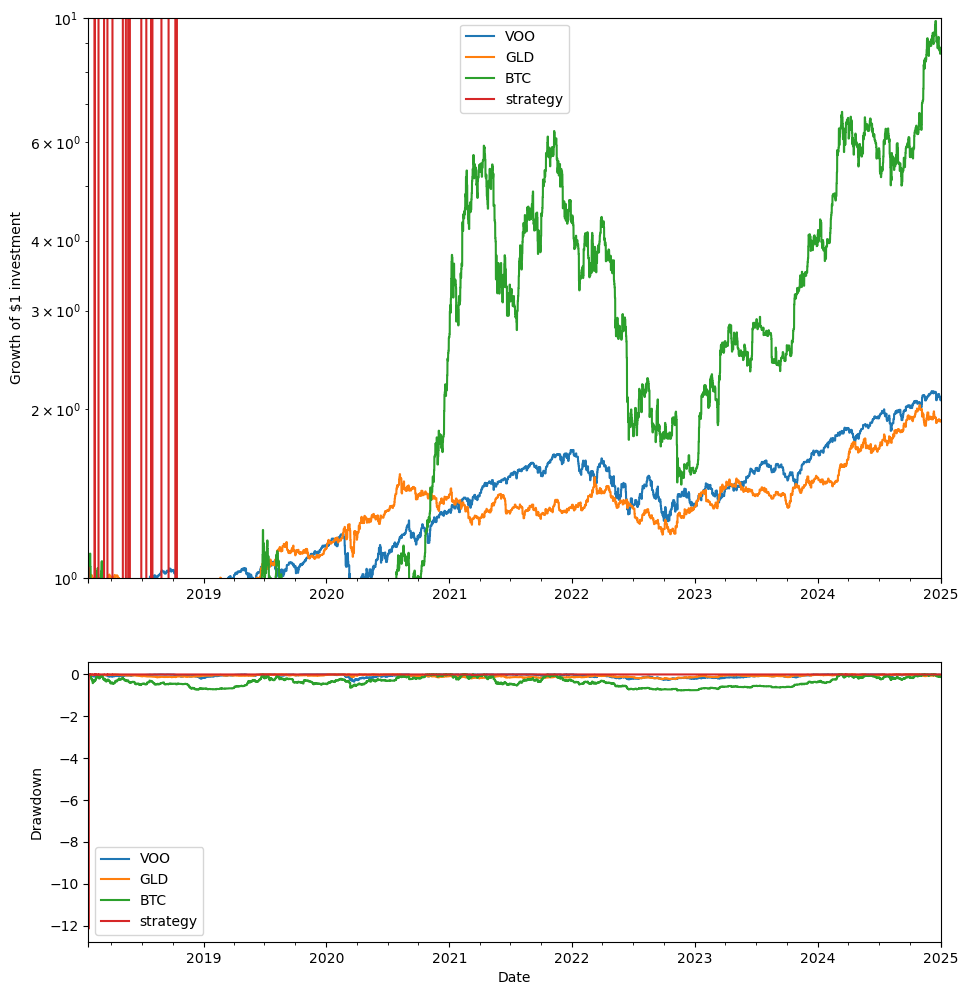

In [77]:
res_dict = at.run(alpha[365*24:],scale_final=False)

In [53]:
at.compute_metrics2(res_dict['returns'],365*24)

{'annual_return': np.float64(2500.552059672666),
 'annual_vol': np.float64(1256.5851560318688),
 'sharpe': np.float64(1.9899344247937694),
 'profit_factor': np.float64(9.68574672362087),
 'sortino': np.float64(10.864664499630985),
 'drawdown': 2018-01-23 00:00:00+00:00    0.000000e+00
 2018-01-23 01:00:00+00:00    0.000000e+00
 2018-01-23 02:00:00+00:00   -8.295440e-01
 2018-01-23 03:00:00+00:00   -7.938040e-01
 2018-01-23 04:00:00+00:00   -7.938040e-01
                                  ...     
 2025-01-01 01:00:00+00:00    0.000000e+00
 2025-01-01 02:00:00+00:00   -5.757213e-07
 2025-01-01 03:00:00+00:00    0.000000e+00
 2025-01-01 04:00:00+00:00   -3.687705e-06
 2025-01-01 05:00:00+00:00   -3.687705e-06
 Name: strategy, Length: 60846, dtype: float64,
 'max_drawdown': np.float64(-11.704597842776037),
 'calmar': np.float64(213.6358799560092)}

In [39]:
returns_df = at.get_data('returns')
returns_df

,da-rp
time,
2017-01-01 06:00:00+00:00,0.005489
2017-01-01 07:00:00+00:00,-0.016269
2017-01-01 08:00:00+00:00,0.028522
2017-01-01 09:00:00+00:00,0.013500
2017-01-01 10:00:00+00:00,-0.005929
...,...
2025-01-01 01:00:00+00:00,0.034664
2025-01-01 02:00:00+00:00,-0.160854
2025-01-01 03:00:00+00:00,-0.119832


In [40]:
alpha_df = alpha.to_frame()
alpha_df

,da-rp
datetime,
2017-01-23 00:00:00+00:00,-1
2017-01-23 01:00:00+00:00,-1
2017-01-23 02:00:00+00:00,-1
2017-01-23 03:00:00+00:00,-1
2017-01-23 04:00:00+00:00,-1
...,...
2025-01-01 01:00:00+00:00,0
2025-01-01 02:00:00+00:00,-1
2025-01-01 03:00:00+00:00,-1


In [55]:
strategy_return = res_dict['returns']
strategy_return

2018-01-23 00:00:00+00:00    0.000000
2018-01-23 01:00:00+00:00    0.044611
2018-01-23 02:00:00+00:00   -0.866551
2018-01-23 03:00:00+00:00    0.037334
2018-01-23 04:00:00+00:00    0.000000
                               ...   
2025-01-01 01:00:00+00:00    0.024664
2025-01-01 02:00:00+00:00   -0.010000
2025-01-01 03:00:00+00:00    0.119832
2025-01-01 04:00:00+00:00   -0.064054
2025-01-01 05:00:00+00:00    0.000000
Name: strategy, Length: 60846, dtype: float64

In [56]:
strategy_return.mean()*24*365

np.float64(2500.552059672666)

In [61]:
filtered_return = strategy_return[strategy_return.between(-np.inf,10)]
filtered_return

2018-01-23 00:00:00+00:00    0.000000
2018-01-23 01:00:00+00:00    0.044611
2018-01-23 02:00:00+00:00   -0.866551
2018-01-23 03:00:00+00:00    0.037334
2018-01-23 04:00:00+00:00    0.000000
                               ...   
2025-01-01 01:00:00+00:00    0.024664
2025-01-01 02:00:00+00:00   -0.010000
2025-01-01 03:00:00+00:00    0.119832
2025-01-01 04:00:00+00:00   -0.064054
2025-01-01 05:00:00+00:00    0.000000
Name: strategy, Length: 60752, dtype: float64

In [62]:
at.compute_metrics2(filtered_return, 24*365)

{'annual_return': np.float64(1572.0585002505168),
 'annual_vol': np.float64(111.2688956445491),
 'sharpe': np.float64(14.128193608323352),
 'profit_factor': np.float64(6.452158972735079),
 'sortino': np.float64(6.8303985453804605),
 'drawdown': 2018-01-23 00:00:00+00:00    0.000000e+00
 2018-01-23 01:00:00+00:00    0.000000e+00
 2018-01-23 02:00:00+00:00   -8.295440e-01
 2018-01-23 03:00:00+00:00   -7.938040e-01
 2018-01-23 04:00:00+00:00   -7.938040e-01
                                  ...     
 2025-01-01 01:00:00+00:00    0.000000e+00
 2025-01-01 02:00:00+00:00   -9.171425e-07
 2025-01-01 03:00:00+00:00    0.000000e+00
 2025-01-01 04:00:00+00:00   -5.874610e-06
 2025-01-01 05:00:00+00:00   -5.874610e-06
 Name: strategy, Length: 60752, dtype: float64,
 'max_drawdown': np.float64(-11.704597842776037),
 'calmar': np.float64(134.30862993902497)}